# Emotion Recognition CNN

## 1. Setup

### 1.1 Import Data from Drive

#### 1.1.1 Mount drive

In [0]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 1.1.2 List the contents of current working directory

In [0]:
!ls

drive  radhakrishna.tar.gz  sample_data  Scaled


#### 1.1.3 Copy the data zip file from Drive to current working directory

In [0]:
!cp drive/'My Drive'/radhakrishna.tar.gz /content
# !cp drive/'My Drive'/krishna.tar.gz /content

#### 1.1.4 Unzip the data zip file

In [0]:
!tar -xvzf radhakrishna.tar.gz
# !tar -xvzf krishna.tar.gz

#### 1.1.5 List all the files in Scaled directory

In [0]:
!cd Scaled/ && ls

Negative  Neutral  Positive


### 1.2 Import required libraries

In [0]:
# Ignore warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# Data Manipulation libraries
import numpy as np
import pandas as pd

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
# Matplotlib and Seaborn configuration
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

# Keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, ZeroPadding2D, AveragePooling2D
from keras.layers.advanced_activations import PReLU

# Tensorflow
import tensorflow as tf

# Image manipulation libraries
import cv2                  
from PIL import Image

# Other libraries
import random
from tqdm import tqdm
import os
import itertools

# Set seed for random number generators
np.random.seed(42)
random.seed(42)
tf.set_random_seed(42)

Using TensorFlow backend.


## 2. Data Preprocessing

In [0]:
# data
X = []
# labels
X_labels = []

# size of the image - 64x64
IMG_SIZE = 64

# assign variables for paths of each class
POSITIVE_DIR = 'Scaled/Positive/'
NEUTRAL_DIR = 'Scaled/Neutral/'
NEGATIVE_DIR = 'Scaled/Negative/'

### 2.1 Function to generate training data from given images and labels

In [0]:
def generate_data_from_images(emotion_type, directory):
  # tqdm used for progress bar
  # for each image in the specified directory
  for image in tqdm(os.listdir(directory)):
    filename = os.fsdecode(image)
    if filename.endswith(".jpg"): 
      # read the colored image
      image = cv2.imread(os.path.join(directory, image))
      # resize image to 64x64
      image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
      
      # append the image as a numpy array to X
      X.append(np.array(image))
      # append the label to Z
      X_labels.append(emotion_type)

### 2.2 Generate data for "Positive" images

In [0]:
generate_data_from_images('Positive', POSITIVE_DIR)

100%|██████████| 16801/16801 [00:03<00:00, 4841.79it/s]


### 2.3 Generate data for "Neutral" images

In [0]:
generate_data_from_images('Neutral', NEUTRAL_DIR)

100%|██████████| 9265/9265 [00:01<00:00, 5081.58it/s]


### 2.4 Generate data for "Negative" images

In [0]:
generate_data_from_images('Negative', NEGATIVE_DIR)

100%|██████████| 8467/8467 [00:01<00:00, 5059.16it/s]


### 2.5 Check the size of the dataset

In [0]:
len(X), len(X_labels)

(34530, 34530)

### 2.6 Visualize some images from the dataset

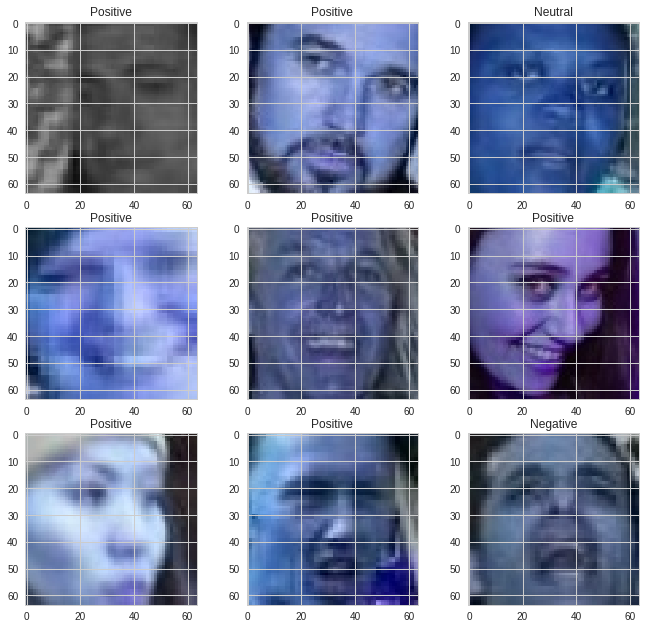

In [0]:
cols = 3
rows = 3
fig, axis = plt.subplots(rows, cols)
fig.set_size_inches(10, 10)
for i in range(rows):
  for j in range(cols):
    image_index = random.randint(0, len(X))
    axis[i, j].imshow(X[image_index])
    axis[i, j].set_title(X_labels[image_index])

### 2.7 Label Encoding and One-Hot Encoding the labels (Convert categorical text data into model-understandable numerical data)
Basically, we want to convert the 3 label classes "positive", "neutral" and "negative" into corresponding numerical classes - 2, 1 and 0.

In [0]:
# initialize the label encoder class
labelencoder = LabelEncoder()

# Convert the 3 classes "positive", "neutral" and "negative" into corresponding 
# numerical classes - 2, 1 and 0.
Y = labelencoder.fit_transform(X_labels)
# Check the classes applied by the Label Encoder
labelencoder_classes = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(labelencoder_classes)
# Apply one-hot encoding to convert the label encoded categorical data
# into multiple columns where each numerical class is replaced by 0 or 1
Y = to_categorical(Y,3)

# Convert X into a numpy array
X = np.array(X)
# Normalize all the pixel values for each image by diving by 255
X = X/255

{'Negative': 0, 'Neutral': 1, 'Positive': 2}


### 2.8 Split the data into training set and validation set

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## 3. Modelling

### 3.1 Building the CNN Model

#### 3.1.1 Model 1

In [0]:
# model = Sequential()
# model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (64,64,3)))
# model.add(MaxPooling2D(pool_size=(2,2)))


# model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

# model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# model.add(Flatten())
# model.add(Dense(512))
# model.add(Activation('relu'))
# model.add(Dense(3, activation = "softmax"))

#### 3.1.2 Model 2

In [0]:
model = Sequential()
model.add(ZeroPadding2D((1,1), input_shape=(64,64,3)))
model.add(Conv2D(32, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(32, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(64, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

'''
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
'''

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

#### 3.1.3 Model 3

In [0]:
# model = Sequential()
# model.add(Conv2D(64, 5, 5, border_mode='valid',
#                         input_shape=(64, 64, 3)))
# model.add(PReLU(init='zero', weights=None))
# model.add(ZeroPadding2D(padding=(2, 2), dim_ordering='tf'))
# model.add(MaxPooling2D(pool_size=(5, 5),strides=(2, 2)))

# model.add(ZeroPadding2D(padding=(1, 1), dim_ordering='tf')) 
# model.add(Conv2D(64, 3, 3))
# model.add(PReLU(init='zero', weights=None))
# model.add(ZeroPadding2D(padding=(1, 1), dim_ordering='tf')) 
# model.add(Conv2D(64, 3, 3))
# model.add(PReLU(init='zero', weights=None))
# model.add(AveragePooling2D(pool_size=(3, 3),strides=(2, 2)))

# model.add(ZeroPadding2D(padding=(1, 1), dim_ordering='tf'))
# model.add(Conv2D(128, 3, 3))
# model.add(PReLU(init='zero', weights=None))
# model.add(ZeroPadding2D(padding=(1, 1), dim_ordering='tf'))
# model.add(Conv2D(128, 3, 3))
# model.add(PReLU(init='zero', weights=None))

# model.add(ZeroPadding2D(padding=(1, 1), dim_ordering='tf'))
# model.add(AveragePooling2D(pool_size=(3, 3),strides=(2, 2)))

# model.add(Flatten())
# model.add(Dense(1024))
# model.add(PReLU(init='zero', weights=None))
# model.add(Dropout(0.2))
# model.add(Dense(1024))
# model.add(PReLU(init='zero', weights=None))
# model.add(Dropout(0.2))

# model.add(Dense(3))

# model.add(Activation('softmax'))

# ada = Adadelta(lr=0.1, rho=0.95, epsilon=1e-08)
# model.compile(loss='categorical_crossentropy',
#               optimizer=ada,
#               metrics=['accuracy'])

#### 3.1.4 Model 4

In [0]:
# model = Sequential()

# # It's easier to design networks if you preserve height and width and don't have to worry too much about tensor dimensions when going from one layer to another because dimensions will just "work".
# model.add(ZeroPadding2D((1,1), input_shape=(64, 64, 3)))

# # Number of filters i.e. first parameter is number of feature maps we want to use(One feature map created for each filter used).
# # Number of filters argument also requires number of rows and columns in feature detector.
# # For the next statement, 32 is number of filters(Feature detectors) you want to use.
# # Usually we start with 32, then go further with 64,128.. 256 in future layers
# # 3, 3 is number of rows and number of columns for Feature Detector.
# # Activation function is relu as per step 1.
# model.add(Conv2D(32, 3, 3, activation='relu'))
# model.add(ZeroPadding2D((1,1)))
# model.add(Conv2D(32, 3, 3, activation='relu'))
# # pool_size is generally (2,2). Will reduce size of feature maps and divide it by 2.
# # In short, we just reduced complexity of our model without affecting performance.
# model.add(MaxPooling2D((2,2), strides=(2,2)))
# model.add(ZeroPadding2D((1,1)))
# model.add(Conv2D(64, 3, 3, activation='relu'))
# model.add(ZeroPadding2D((1,1)))
# model.add(Conv2D(64, 3, 3, activation='relu'))
# model.add(MaxPooling2D((2,2), strides=(2,2)))
# model.add(ZeroPadding2D((1,1)))
# model.add(Conv2D(128, 3, 3, activation='relu'))
# model.add(ZeroPadding2D((1,1)))
# model.add(Conv2D(128, 3, 3, activation='relu'))
# model.add(ZeroPadding2D((1,1)))
# model.add(Conv2D(128, 3, 3, activation='relu'))
# model.add(MaxPooling2D((2,2), strides=(2,2)))

# # Take all pooled feature maps and put in into one huge vector(Spatial information preserved)
# model.add(Flatten())

# # Dense is used to add fully connected layer.
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(3, activation='softmax'))

#### 3.1.5 Model 5

In [0]:
# model = Sequential()

# model.add(Conv2D(filters = 64, kernel_size = (11,11),padding = 'Same',activation ='relu', input_shape = (64,64,3)))
# model.add(MaxPooling2D(pool_size=(3,3)))

# model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',activation ='relu'))
# model.add(MaxPooling2D(pool_size=(3,3)))

# model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))

# model.add(Flatten())
# model.add(Dense(512))
# model.add(Activation('relu'))
# model.add(Dense(3, activation = "softmax"))

# rmsprop = RMSprop(lr=0.001, epsilon=1e-10, decay=0.9)
# model.compile(loss='categorical_crossentropy',
#               optimizer=rmsprop,
#               metrics=['accuracy'])

### 3.2 Set Model Training Parameters

In [0]:
# batch_size=128
batch_size = 64
# epochs=10

### 3.3 Data Augmentation

In [0]:
# define the data generator
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        zoom_range = 0.1, 
        vertical_flip=False)

# fit on our training set
datagen.fit(X_train)

### 3.4 Compile the Model

In [0]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### 3.5 Model Summary

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_8 (ZeroPaddin (None, 66, 66, 3)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
zero_padding2d_9 (ZeroPaddin (None, 66, 66, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
zero_padding2d_10 (ZeroPaddi (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 64)        18496     
__________

### 3.6 Estimate class weights since our dataset is unbalanced

In [0]:
# get the position of the largest value for each label in y_train
# eg - argmax([0., 0., 1.]) = 2
y_ints = [y.argmax() for y in y_train]
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_ints), y_ints)

### 3.7 Fit the model on the Training set and making predictions on the Validation set

In [0]:
callbacks = []
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
callbacks.append(earlystop)

history = model.fit(X_train,y_train, nb_epoch=400, \
            batch_size=batch_size, \
            validation_split=0.2, \
            shuffle=True, verbose=1, \
            callbacks=callbacks, class_weight=class_weights)

# history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
#                               epochs = 400, validation_data = (X_test,y_test),
#                               verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size, callbacks=callbacks, class_weight=class_weights)

# history = model.fit(x_train,y_train,epochs=400,batch_size=batch_size,validation_data = (x_test,y_test), callbacks=callbacks)

Train on 22099 samples, validate on 5525 samples
Epoch 1/400
22099/22099 [==============================] - 31s 1ms/step - loss: 1.0325 - acc: 0.4879 - val_loss: 1.0158 - val_acc: 0.4878
Epoch 2/400
22099/22099 [==============================] - 29s 1ms/step - loss: 0.9773 - acc: 0.5209 - val_loss: 0.9234 - val_acc: 0.5430
Epoch 3/400
22099/22099 [==============================] - 29s 1ms/step - loss: 0.9213 - acc: 0.5499 - val_loss: 0.8941 - val_acc: 0.5484
Epoch 4/400
22099/22099 [==============================] - 29s 1ms/step - loss: 0.8784 - acc: 0.5790 - val_loss: 0.8690 - val_acc: 0.5911
Epoch 5/400
22099/22099 [==============================] - 29s 1ms/step - loss: 0.8547 - acc: 0.5957 - val_loss: 0.8325 - val_acc: 0.5996
Epoch 6/400
22099/22099 [==============================] - 29s 1ms/step - loss: 0.8280 - acc: 0.6130 - val_loss: 0.8345 - val_acc: 0.5998
Epoch 7/400
22099/22099 [==============================] - 29s 1ms/step - loss: 0.8151 - acc: 0.6181 - val_loss: 0.8365 - v

### 3. Save the Model and weights

In [0]:
model.save("radhakrishna.h5")
model.save_weights("hanuman.h5")

## 4. Evaluate Model Performance

### 4.1 Loss vs Epochs Graph

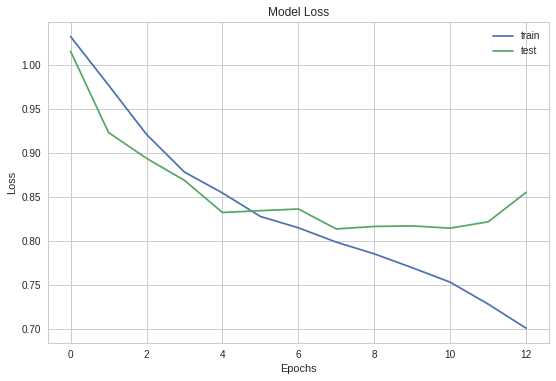

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

### 4.2 Accuracy vs Epochs Graph

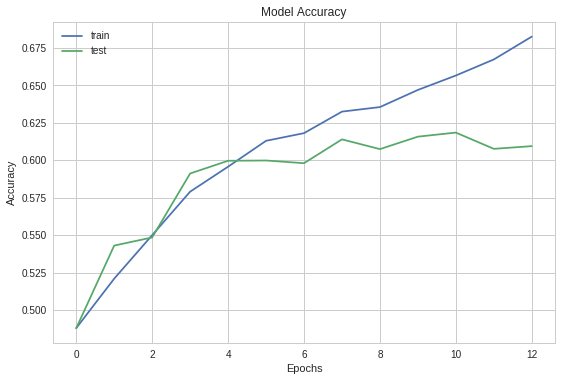

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

### 4.3 Confusion Matrix

#### 4.3.1 Get the predictions on the validation set

In [0]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1) 

#### 4.3.2 Function to plot the confusion matrix

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Credit: https://github.com/scikit-learn/scikit-learn/blob/master/examples/model_selection/plot_confusion_matrix.py
    """
    np.set_printoptions(precision=2)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

#### 4.3.3 Plot the Confusion Matrix

Confusion matrix, without normalization
[[1011  335  327]
 [ 619  713  526]
 [ 462  335 2578]]


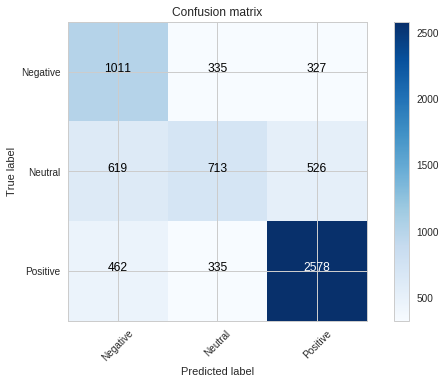

In [0]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure()
plot_confusion_matrix(cm, classes=labelencoder.classes_)
plt.show()

### 4.4 Calculate the Accuracy on the Validation Set

In [0]:
accuracy_score(y_true, y_pred_classes)

0.6229365768896612

## 5. Test Model with a new image

### 5.1 Upload the file

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving pos_824_face_1.jpg to pos_824_face_1.jpg
User uploaded file "pos_824_face_1.jpg" with length 2911 bytes


### 5.2 Process the image for the model

In [0]:
# Load the image and resize to 64X64
image = load_img('pos_824_face_1.jpg', target_size=(64, 64))
# Covert to a numpy array
image = img_to_array(image)
# Normalize it
image = image / 255
# Expand dimensions
image = np.expand_dims(image, axis=0)

### 5.3 Get Predictions

In [0]:
# Get the predicted probabilities for each class
pred = model.predict(image)
# Get the class with the highest probability
pred_digits=np.argmax(pred,axis=1)
# Print the classes assigned by the label encoder
print(labelencoder_classes)
print(pred[0], pred_digits)

{'Negative': 0, 'Neutral': 1, 'Positive': 2}
[0.04 0.21 0.75] [2]


## 6. Download the model and weights

In [0]:
files.download('radhakrishna.h5')
files.download('hanuman.h5')

---

In [0]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

In [0]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Emotion : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Emotion : "+str(le.inverse_transform(np.argmax([y_test[prop_class[count]]]))))
        plt.tight_layout()
        count+=1

In [0]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Emotion : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Emotion : "+str(le.inverse_transform(np.argmax([y_test[mis_class[count]]]))))
        plt.tight_layout()
        count+=1